In [231]:
import pandas as pd
import numpy as np
from pandas import Series


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [232]:
# , encoding = 'ISO-8859-1',low_memory = False
vis_data = pd.read_csv("train.csv")
vis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [233]:
vis_data.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


In [234]:
# создать столбец с датой
vis_data['date_'] = pd.to_datetime(vis_data.app_date, format='%d%b%Y')

In [235]:
# создать столбец с днем недели
vis_data['wd'] = vis_data['date_'].dt.weekday

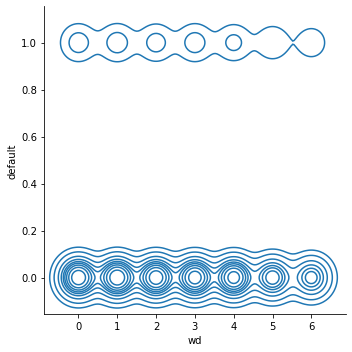

In [236]:
# попытка увидеть зависимость дефолтов от дня недели
sns.displot(data=vis_data, x="wd", y='default', kind='kde')

In [237]:
grpwd = vis_data[['wd', 'default']].value_counts()
grpwd = grpwd.reset_index()
grpwd.columns = ['wd', 'default', 'cnt']
grp = grpwd.groupby('wd')['cnt'].sum()
grpwd['ratio'] = grpwd.apply(lambda x: x.cnt/grp[x.wd], axis=1)
grpwd
# процент дефолтов заметно не зависит от дня недели

,wd,default,cnt,ratio
0,1,0,10625,0.872618
1,0,0,10496,0.872921
2,2,0,10281,0.875724
3,3,0,10082,0.868015
4,4,0,9912,0.880050
5,5,0,7153,0.869032
6,6,0,5878,0.870815
7,1,1,1551,0.127382
8,3,1,1533,0.131985
9,0,1,1528,0.127079


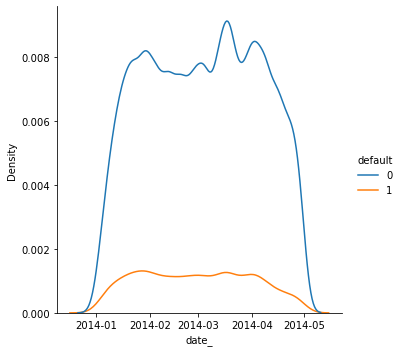

In [238]:
# имеющийся диапазон данных с января по май 2014 года не показывает какой-либо зависимости дефолтов от даты
sns.displot(data=vis_data, x="date_", kind="kde", hue="default")

In [239]:
# на основании первичного осмотра - удалить ненужные столбцы
vis_data.drop(columns=['app_date', 'date_', 'wd'], inplace=True)
vis_data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [240]:
# в столбце education пропущены данные
vis_data.isna().sum()

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [241]:
# заменить пропущенный тип образования на "другой" и проанализировать
vis_data['education'].fillna('other', axis=0, inplace=True)
vis_data['education'].unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', 'other'], dtype=object)

In [242]:
vis_data['edu'] = vis_data.apply(lambda x: x.education == 'other', axis=1)
vis_data

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,edu
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,False
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,False
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,False
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,False
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0,False
73795,76821,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0,False
73796,103695,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0,False
73797,861,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,False


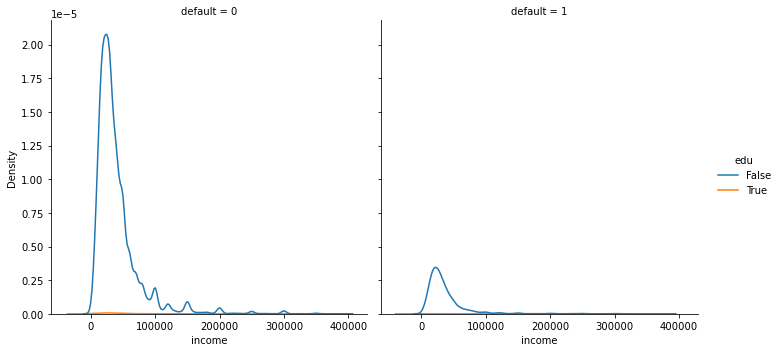

In [243]:

sns.displot(data=vis_data[vis_data.income<400000], x="income", hue="edu", col="default", kind="kde")

In [244]:
edudef = vis_data[['edu', 'default']].value_counts()
display(edudef, "notnaedu", edudef[0][1]/edudef[0]
        [0], "naedu", edudef[1][1]/edudef[1][0],)

edu    default
False  0          64155
       1           9337
True   0            272
       1             35
dtype: int64

'notnaedu'

0.14553814979346893

'naedu'

0.12867647058823528

In [245]:
edudef = vis_data[['education', 'default']].value_counts()
display(edudef)
# вывести отношение дефолтных клиентов к недефолтным в зависимости от образования
for i in edudef.index:
    if i[1] == 0:
        print(i[0], "default=1/default=0",
              edudef.loc[(i[0], 1)]/edudef.loc[(i[0], 0)])

education  default
SCH        0          33008
GRD        0          21260
UGR        0           8525
SCH        1           5852
GRD        1           2105
UGR        1           1291
PGR        0           1176
other      0            272
ACD        0            186
PGR        1             81
other      1             35
ACD        1              8
dtype: int64

SCH default=1/default=0 0.17729035385361125
GRD default=1/default=0 0.09901222953904046
UGR default=1/default=0 0.15143695014662756
PGR default=1/default=0 0.06887755102040816
other default=1/default=0 0.12867647058823528
ACD default=1/default=0 0.043010752688172046


In [246]:
#по соотношению дефолт1/дефолт0=0.12 для пропущенного типа образования
#не заметна выраженная связь с целевой переменной или принадлежность его к какому-нибудь из известных типов SCH...ACD

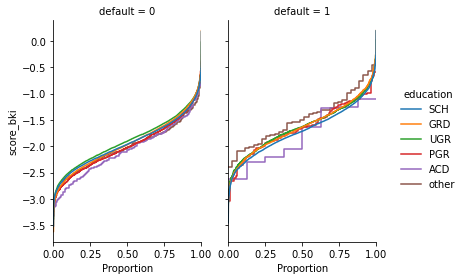

In [247]:
sns.displot(
    data=vis_data, y="score_bki", hue="education", col="default",
    kind="ecdf", height=4, aspect=0.7,
)

<AxesSubplot:>

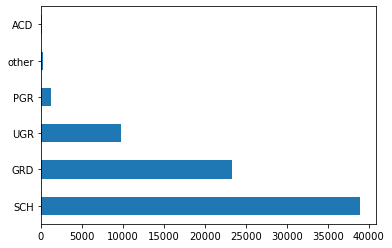

In [248]:
# по результатам анализа не заметно выраженное влияние на целевую переменную,
# для клиентов с пропусками в графе education
# можно оставить пропущеный тип, как other и не причислять к одному или нескольким из известных типоу
vis_data['education'].value_counts().plot.barh()

In [249]:
#удалить тестовый столбец
vis_data.drop(columns=['edu'], inplace=True)
vis_data.head(2)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


In [284]:
bin_cols = []
cat_cols = []
num_cols = []
print("разбивка столбцов на бинарные, категориальные и числовые признаки")
for i in vis_data.columns:
    tmp = vis_data[i].unique()
    if len(tmp) == 2:
        if i != 'default':
            bin_cols.append(i)
    elif len(tmp) < 10:
        cat_cols.append(i)
    else:
        if i != 'client_id':
            num_cols.append(i)
display("бинарные:", bin_cols, "категориальные:",
        cat_cols, "числовые:", num_cols)
print("отображение многообразия вариаций нечисловых столбцов")
tmp = bin_cols.copy()
tmp.extend(cat_cols)
for i in tmp:
    print(i, ":", vis_data[i].unique())

разбивка столбцов на бинарные, категориальные и числовые признаки


'бинарные:'

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

'категориальные:'

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

'числовые:'

['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

отображение многообразия вариаций нечисловых столбцов
sex : ['M' 'F']
car : ['Y' 'N']
car_type : ['Y' 'N']
good_work : [0 1]
foreign_passport : ['N' 'Y']
education : ['SCH' 'GRD' 'UGR' 'PGR' 'ACD' 'other']
region_rating : [50 80 60 40 70 20 30]
home_address : [1 2 3]
work_address : [2 3 1]
sna : [4 1 2 3]
first_time : [1 4 3 2]


<AxesSubplot:xlabel='default', ylabel='count'>

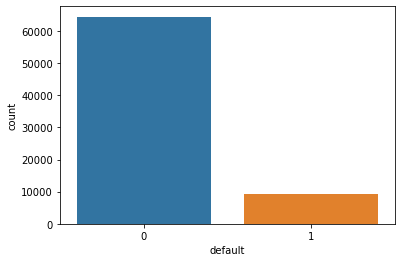

In [251]:
sns.countplot(x='default',data=vis_data)
#несбалансированная выборка по целевой переменной

In [252]:
vis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   education         73799 non-null  object 
 2   sex               73799 non-null  object 
 3   age               73799 non-null  int64  
 4   car               73799 non-null  object 
 5   car_type          73799 non-null  object 
 6   decline_app_cnt   73799 non-null  int64  
 7   good_work         73799 non-null  int64  
 8   score_bki         73799 non-null  float64
 9   bki_request_cnt   73799 non-null  int64  
 10  region_rating     73799 non-null  int64  
 11  home_address      73799 non-null  int64  
 12  work_address      73799 non-null  int64  
 13  income            73799 non-null  int64  
 14  sna               73799 non-null  int64  
 15  first_time        73799 non-null  int64  
 16  foreign_passport  73799 non-null  object

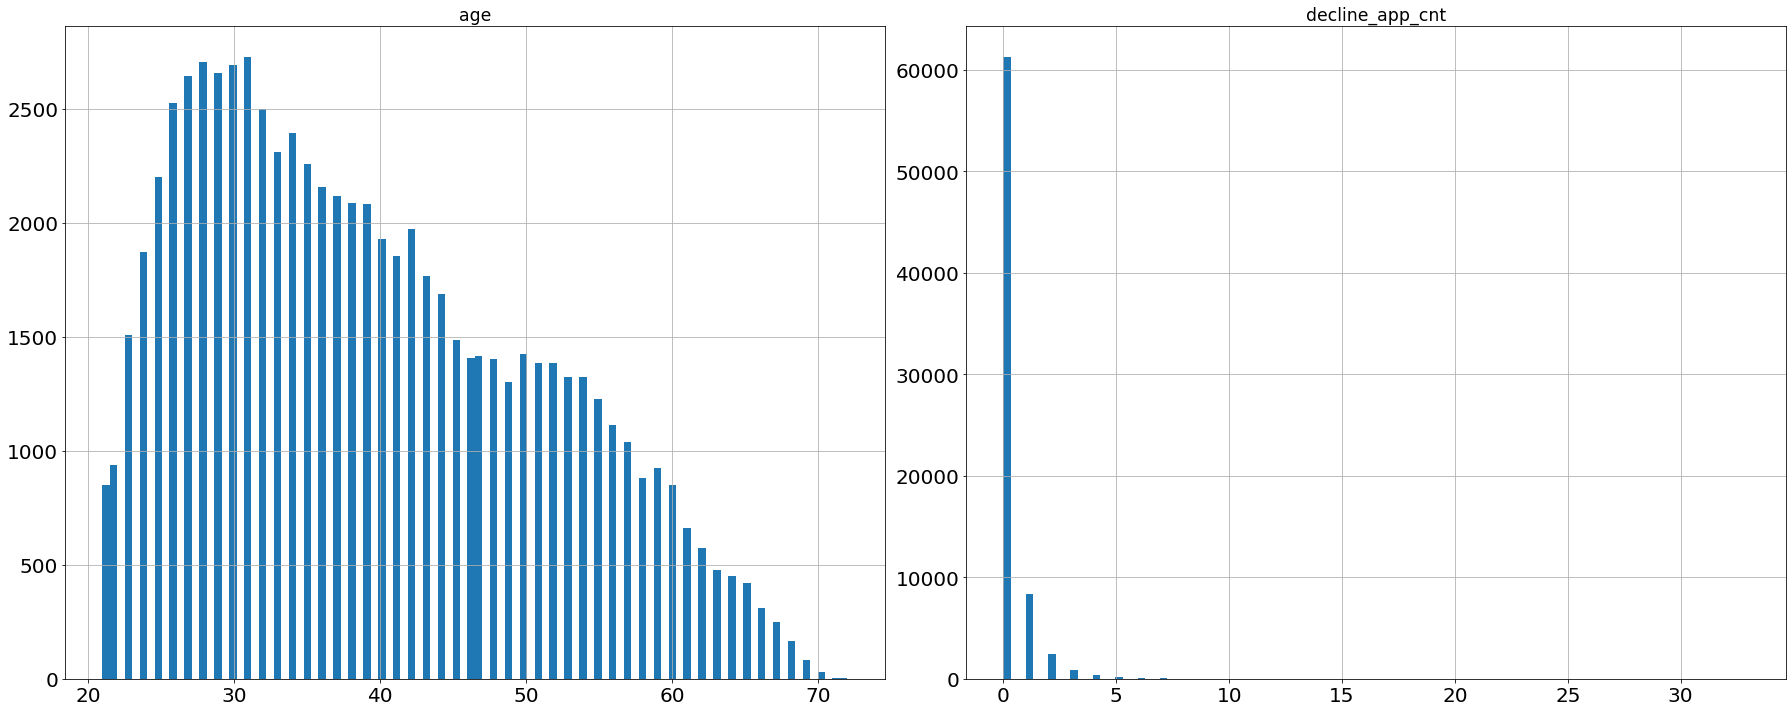

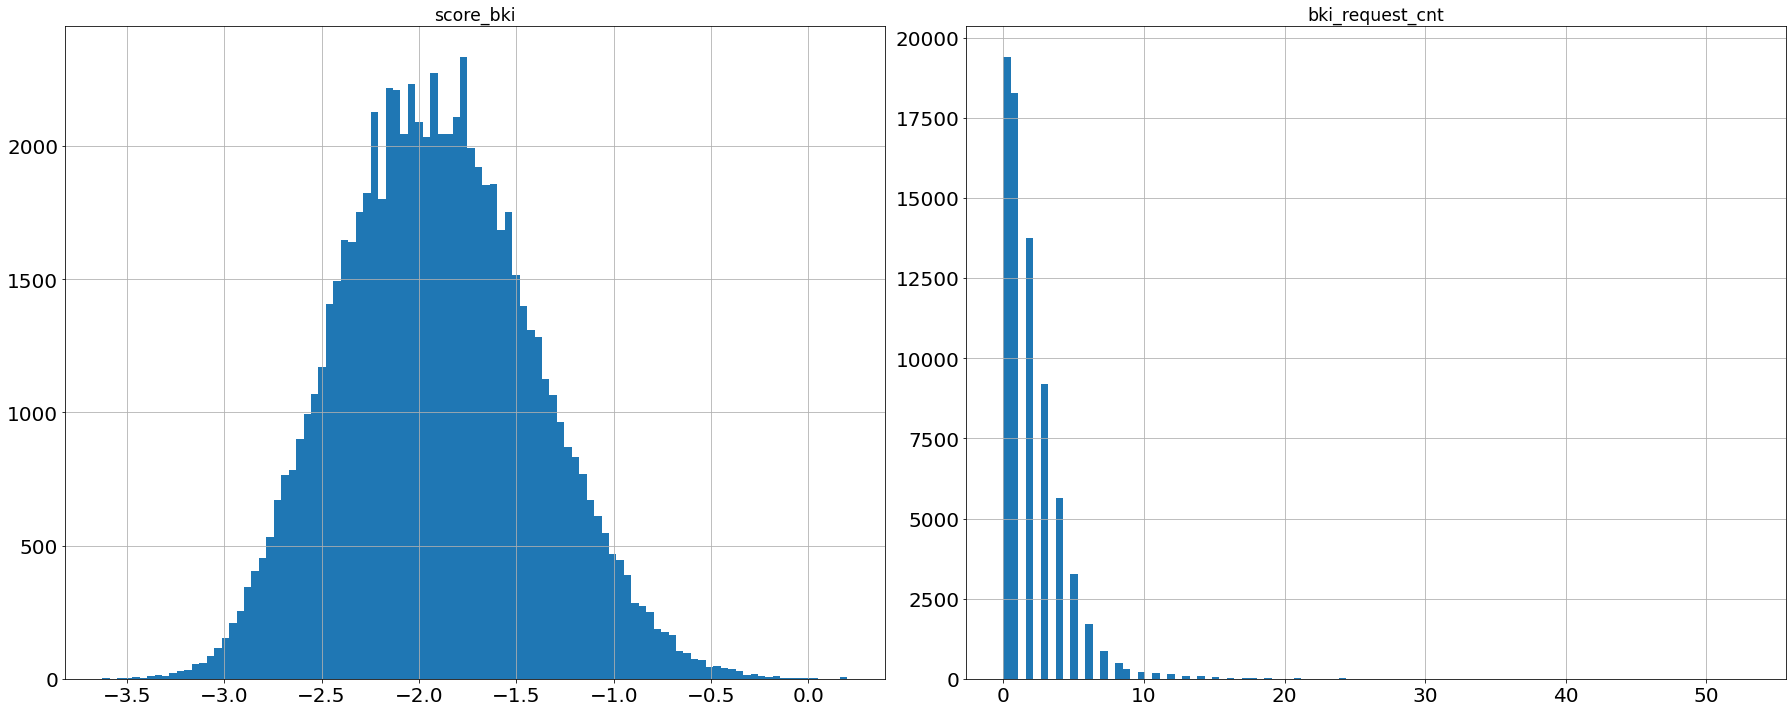

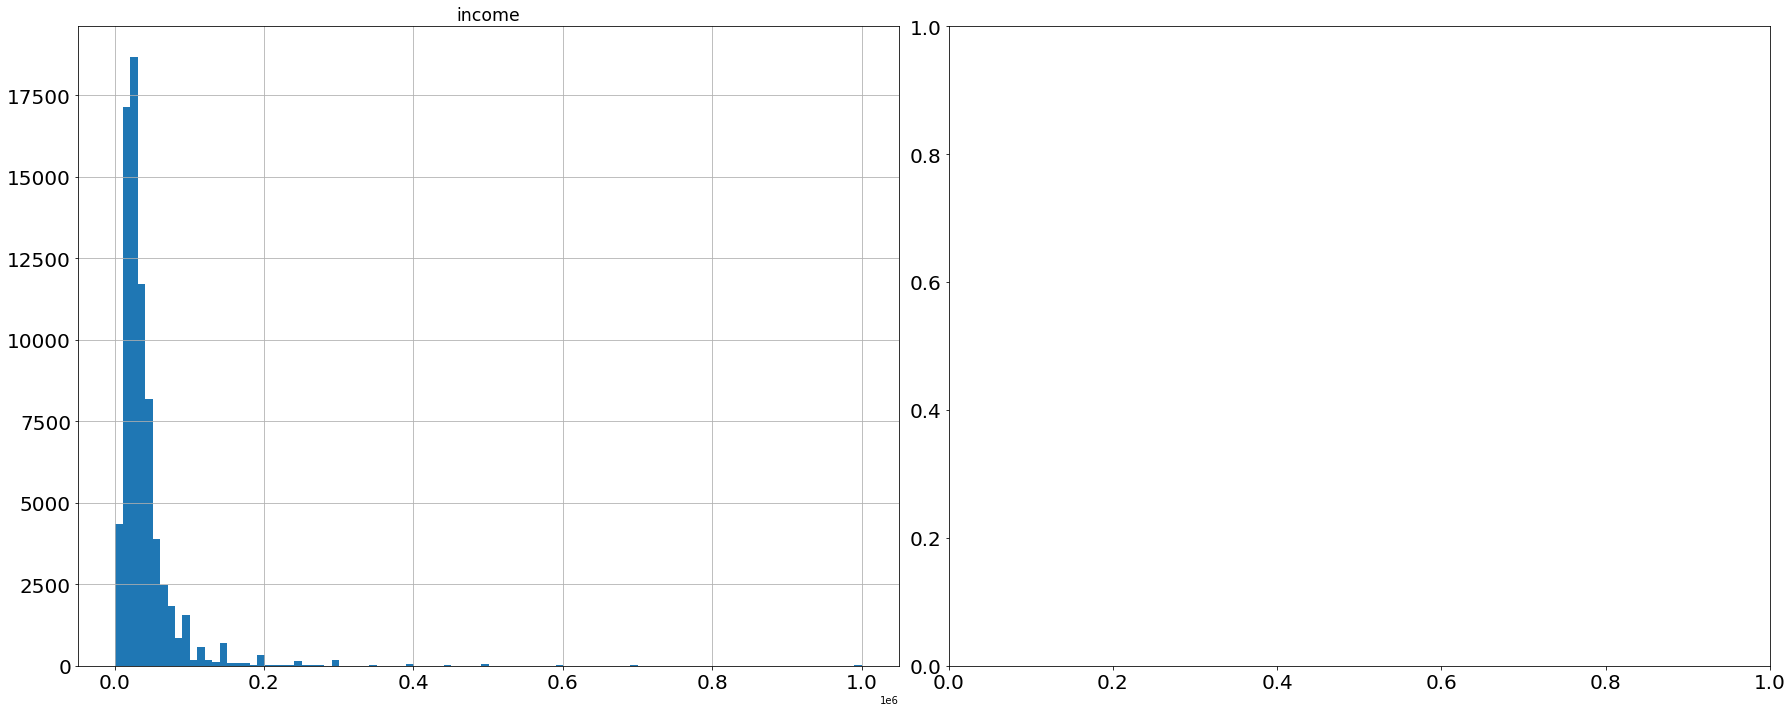

In [263]:
# рассмотреть распределение числовых признаков
def numplothist(df,diagtype="hist"):
    for i in range(0, len(num_cols), 2):
        fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(25, 10))
        for axi in range(2):
            for labelx, labely in zip(ax[0, axi].xaxis.get_ticklabels(), ax[0, axi].yaxis.get_ticklabels()):
                labelx.set_fontsize(20)
                labely.set_fontsize(20)
        comb = [num_cols[i]]
        ax[0, 0].set_title(comb[0], fontsize='xx-large')
        if i < len(num_cols)-1:
            comb.append(num_cols[i+1])
            ax[0, 1].set_title(comb[1], fontsize='xx-large')
            if diagtype == "boxplot":
                ax[0, 0].set_xlabel('default',fontsize='xx-large')
                ax[0, 1].set_xlabel('default',fontsize='xx-large')
                sns.boxplot(x="default", y=comb[0], data=df, ax=ax[0, 0])
                sns.boxplot(x="default", y=comb[1], data=df, ax=ax[0, 1])
            else:
                df[comb[0]].hist(ax=ax[0, 0], bins=100)
                df[comb[1]].hist(ax=ax[0, 1], bins=100)
        else:
            if diagtype == "boxplot":
                ax[0, 0].set_xlabel('default',fontsize='xx-large')
                sns.boxplot(x="default", y=comb[0], data=df, ax=ax[0, 0])
            else:
                df[comb[0]].hist(ax=ax[0, 0], bins=100)
        plt.tight_layout()


numplothist(vis_data)

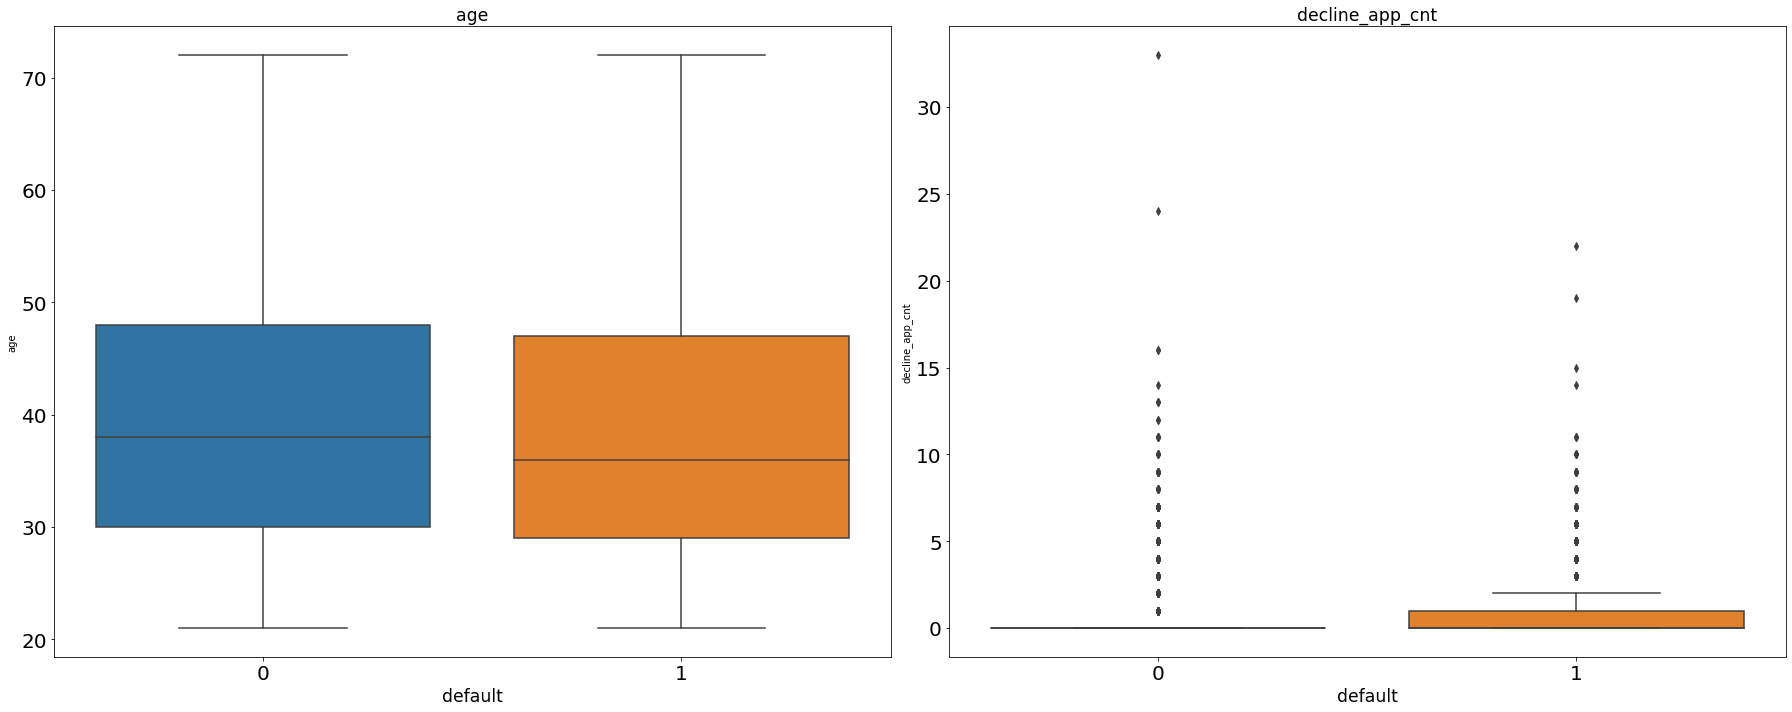

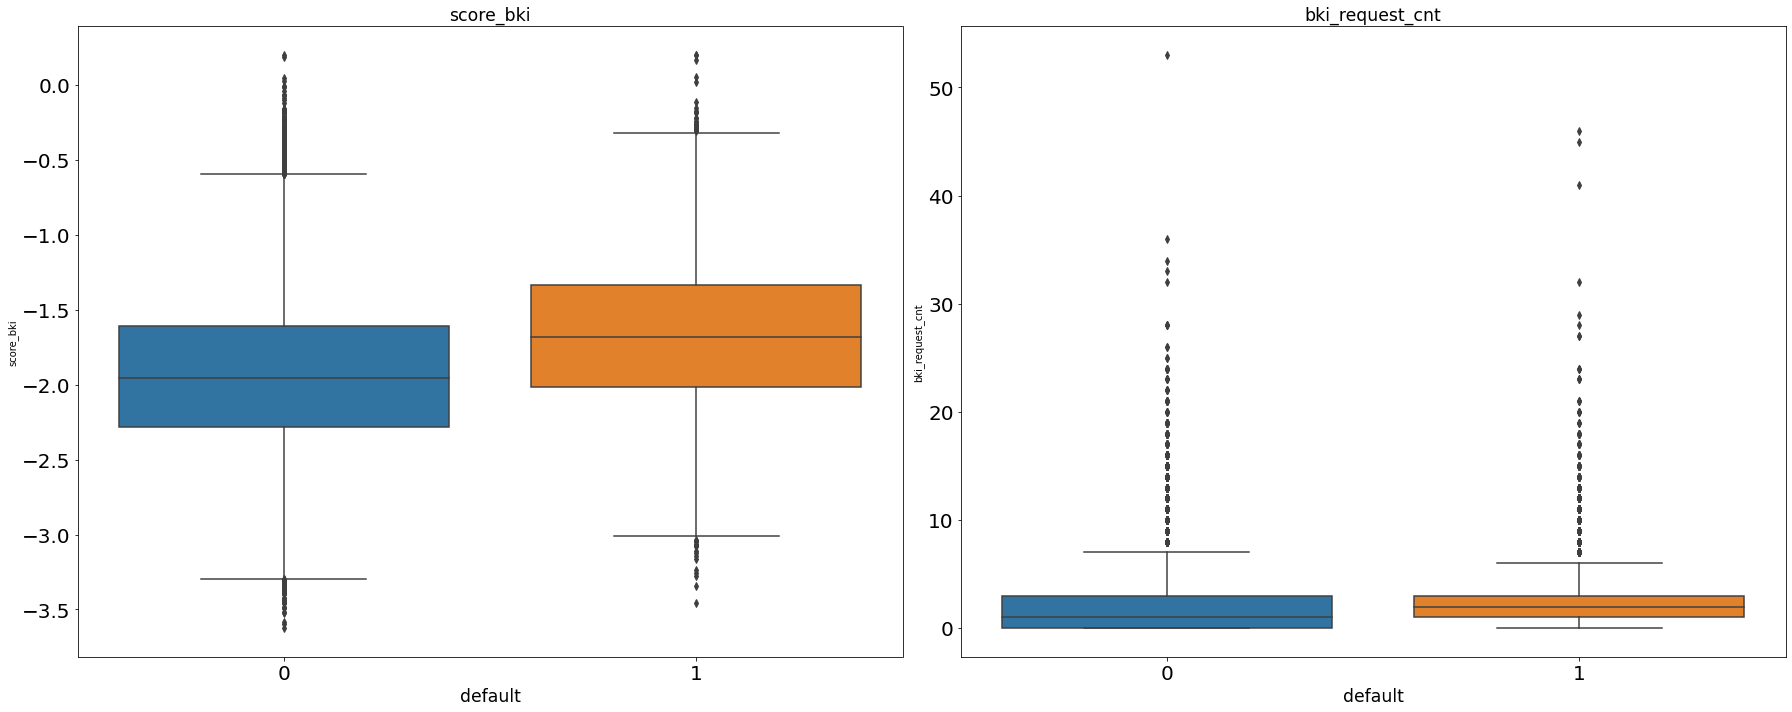

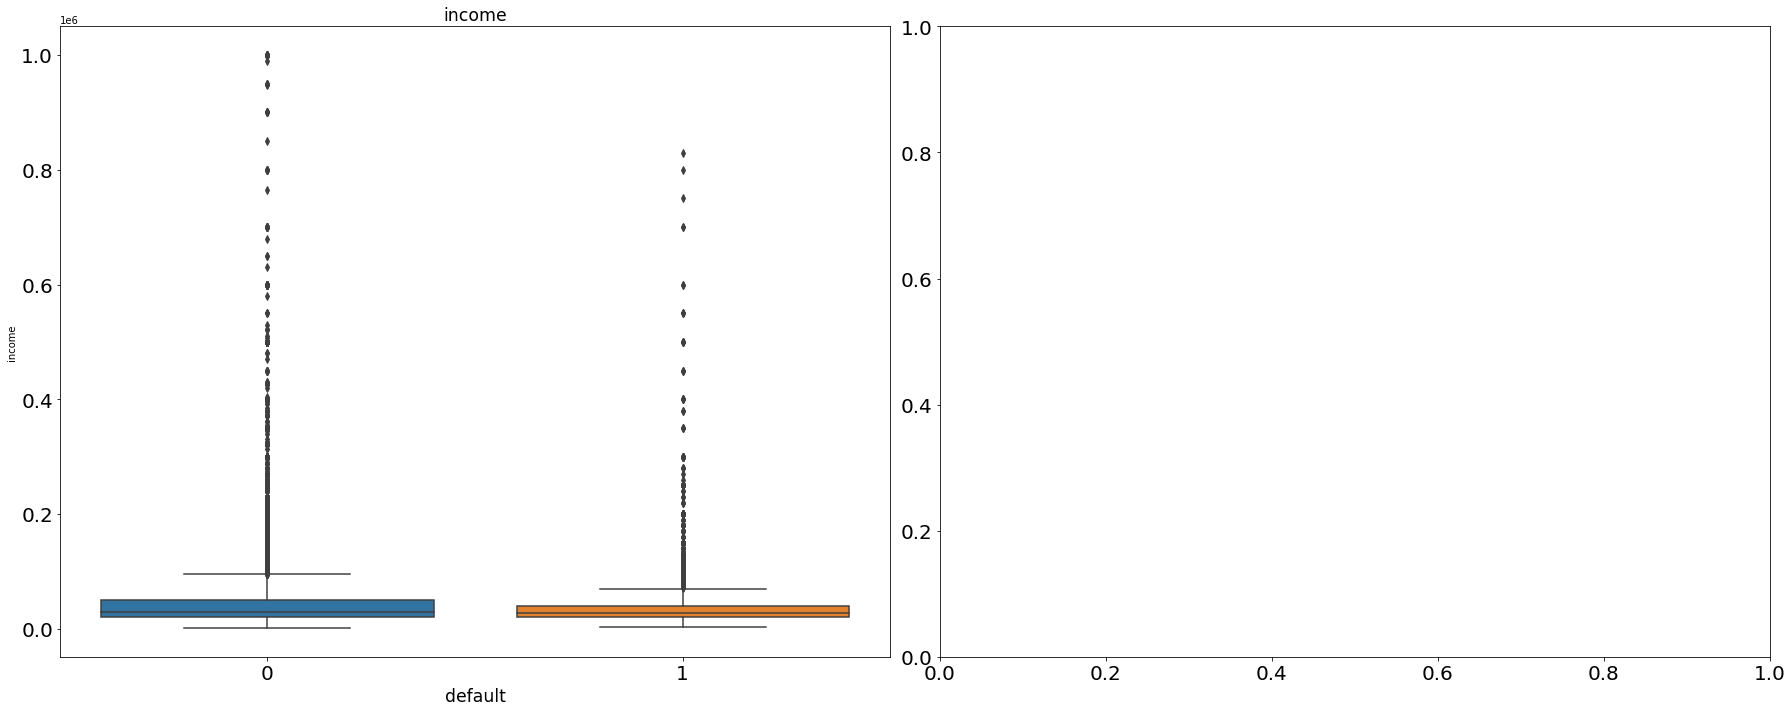

In [264]:
numplothist(vis_data,"boxplot")

<AxesSubplot:xlabel='income', ylabel='Count'>

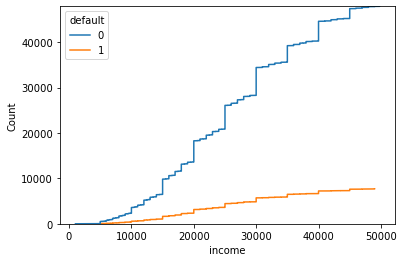

In [255]:
sns.ecdfplot(data=vis_data[vis_data.income<50000], x="income",hue='default',stat="count")

<AxesSubplot:xlabel='income', ylabel='Count'>

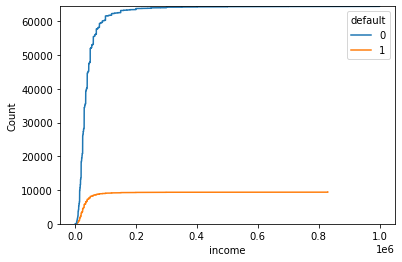

In [256]:
sns.ecdfplot(data=vis_data, x="income",hue='default',stat="count")
#среди клиентов с разным доходом - доля не отдающих кредиты сохраняется почти неизменной

In [257]:
#создать рабочую копию выборки
df=vis_data.copy()
#распределение признаков 'decline_app_cnt','bki_request_cnt', 'income' - 
#будет иметь более удобный для анализа вид, если их прологарифмировать
for i in ['decline_app_cnt','bki_request_cnt', 'income']:
    df[i] = df[i].apply(lambda w: np.log(w + 1))

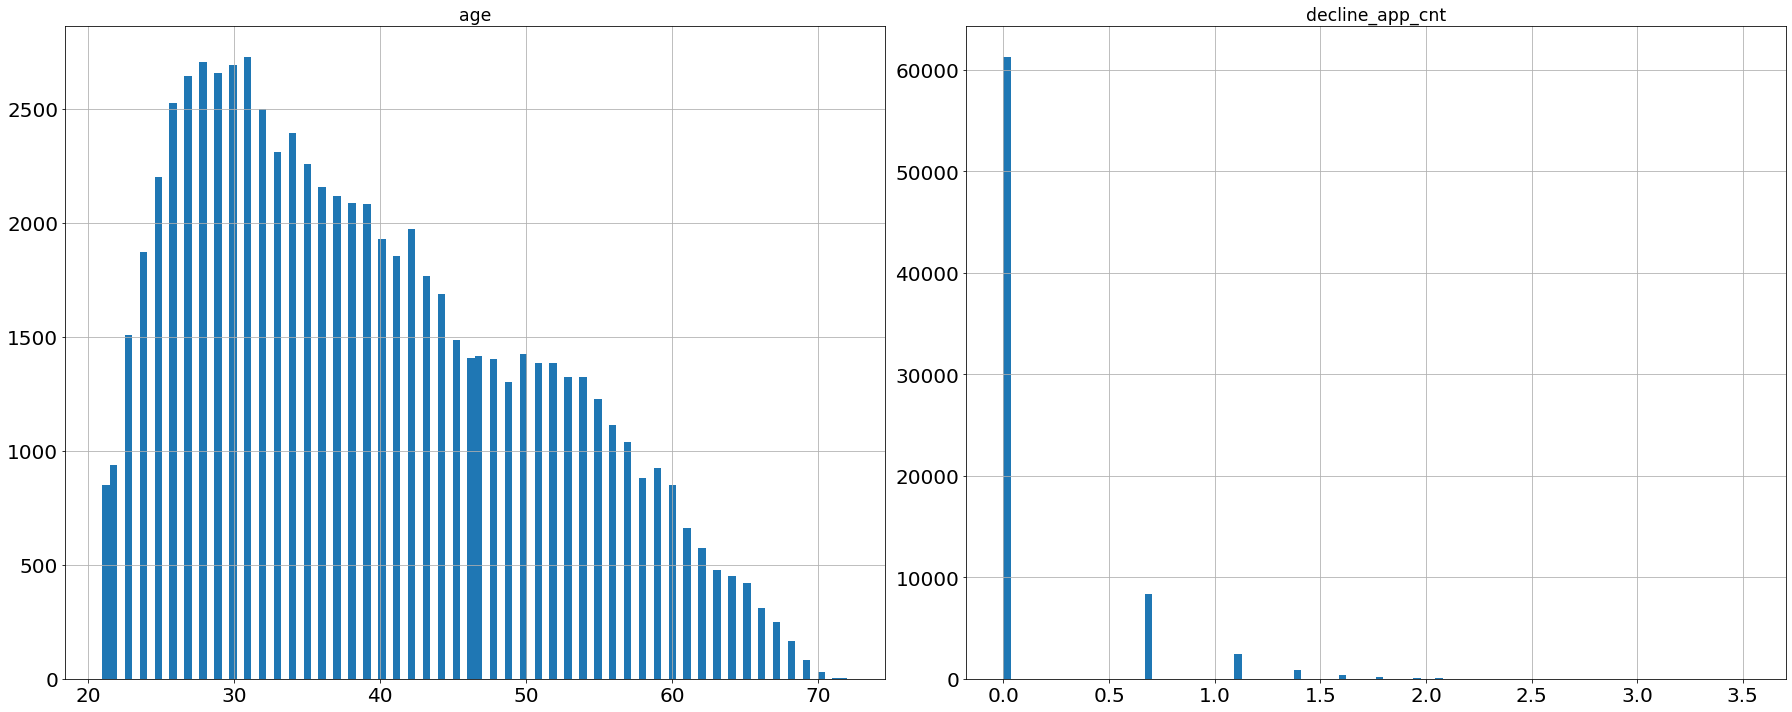

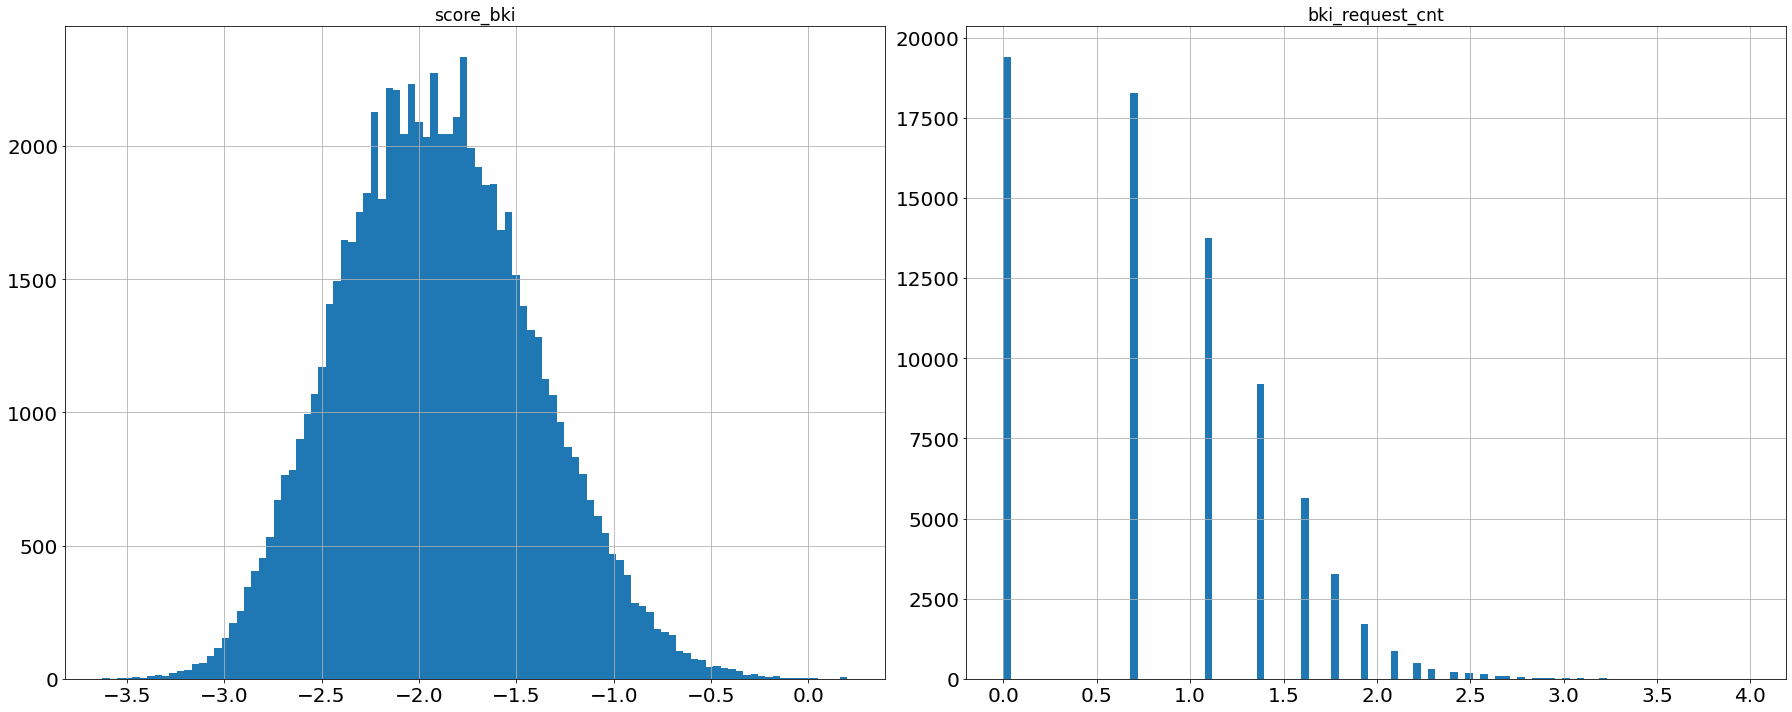

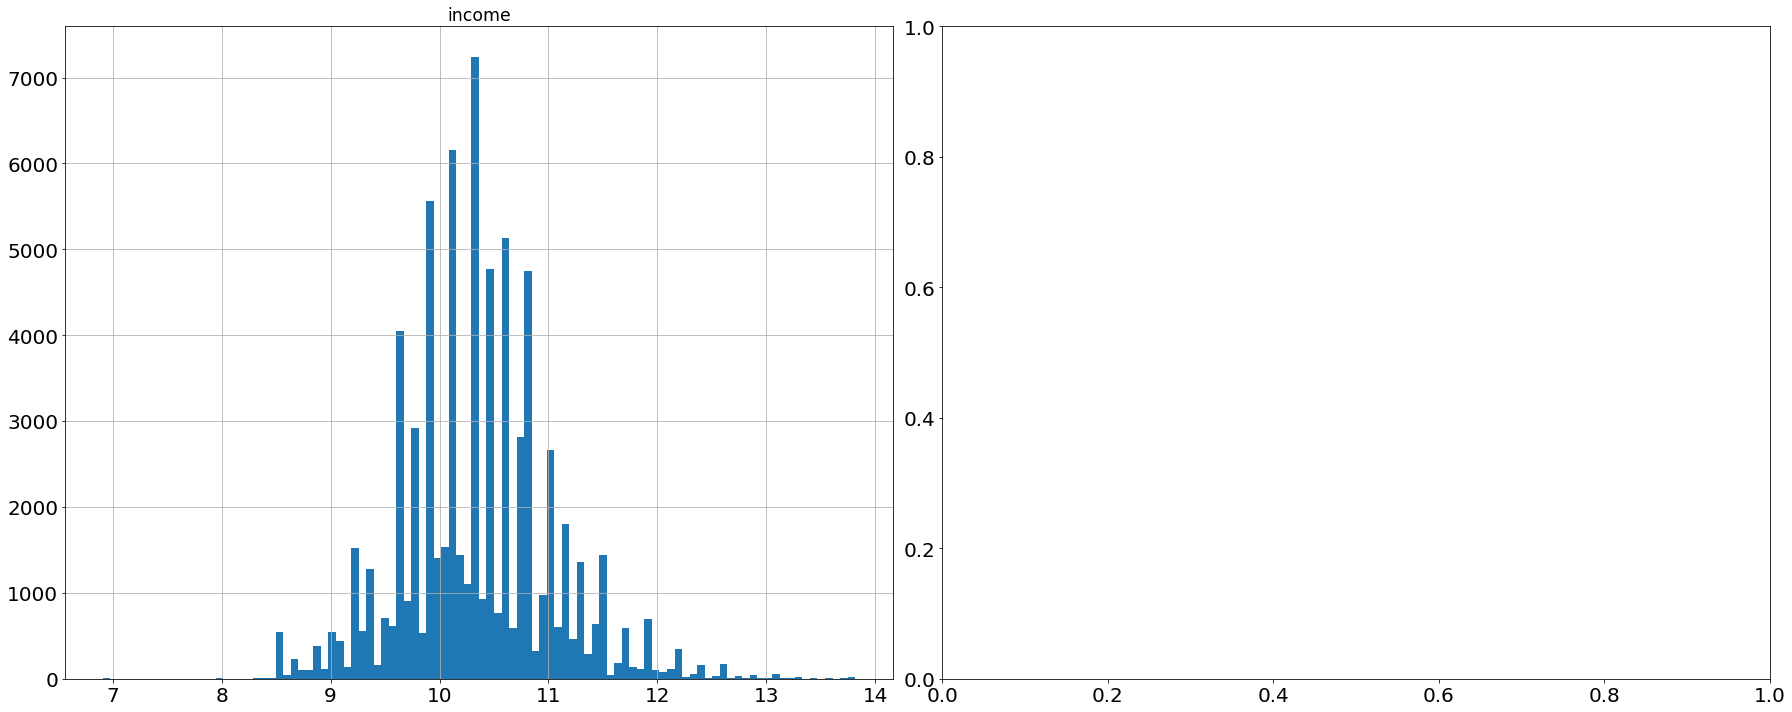

In [265]:
numplothist(df)

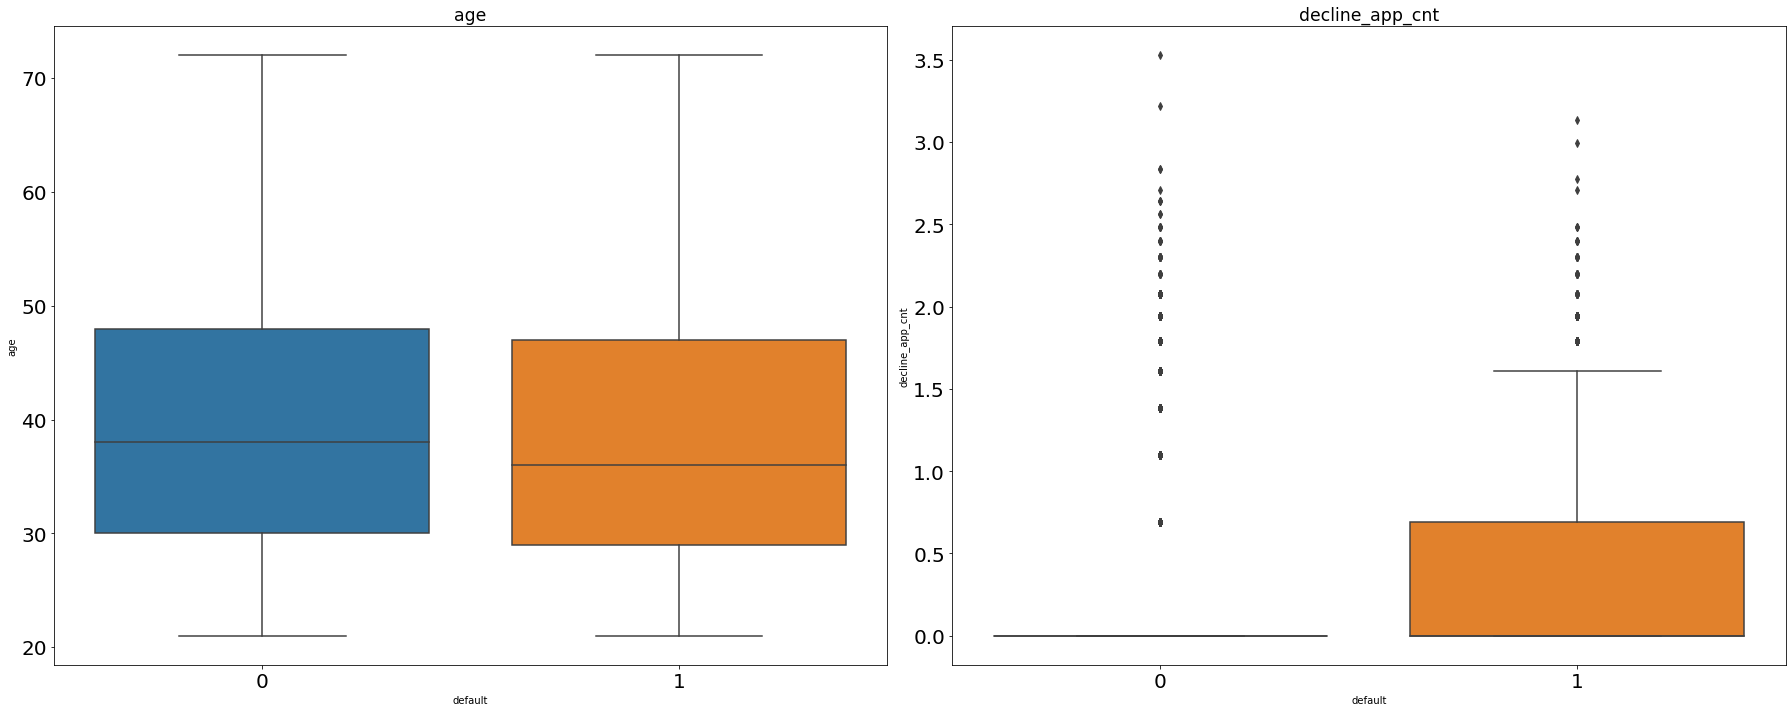

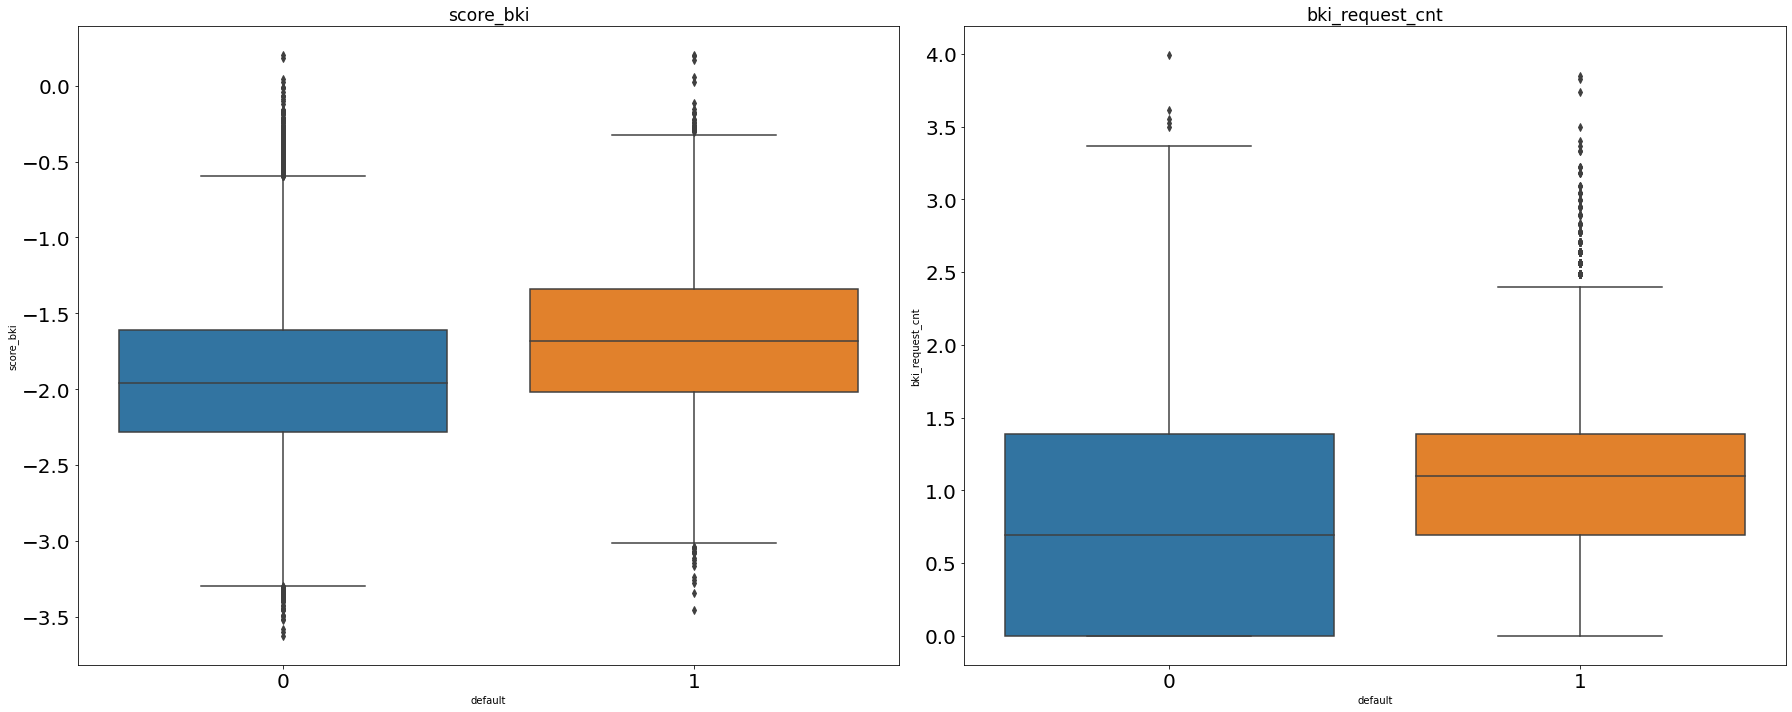

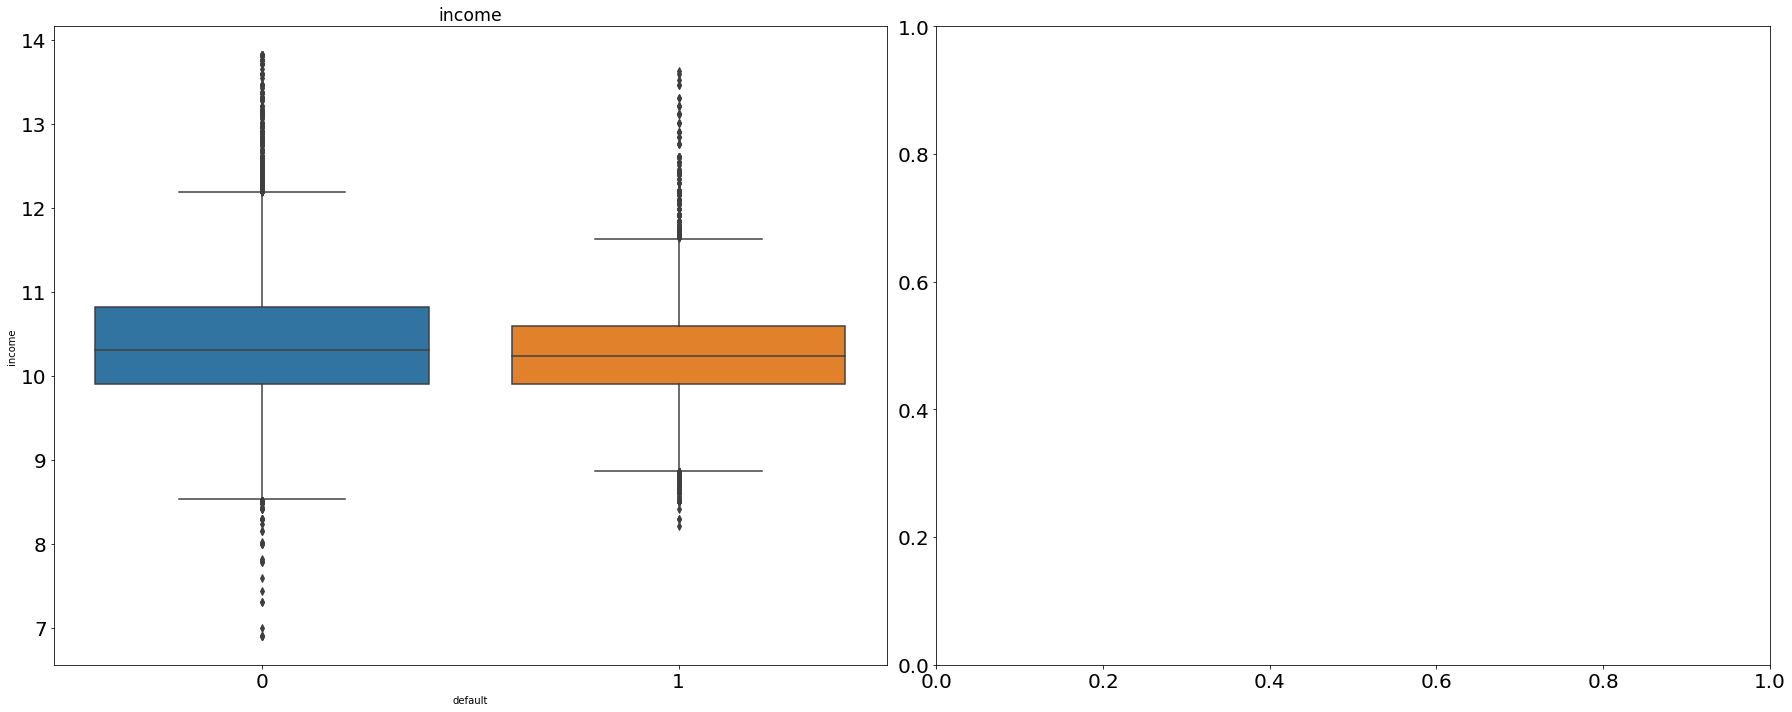

In [259]:

numplothist(df,"boxplot")

<AxesSubplot:>

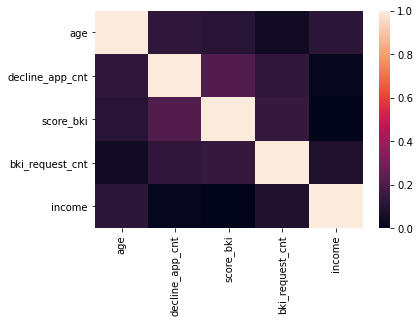

In [266]:
#оценка корелляции числовых признаков:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)
#связь признаков между собой низкая

<AxesSubplot:>

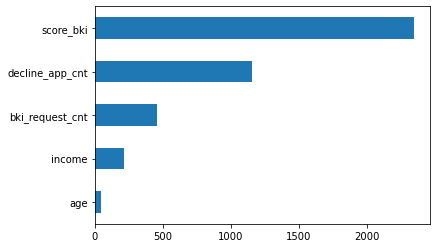

In [269]:
#оценка значимости числовых признаков
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
#наиболее значимые признаки 'score_bki','decline_app_cnt'

In [276]:
#выполнить кодировку бинарных и категориальных(строковых) признаков в цифру:
#(((!!!промежуточные оценки до использования OneHotEncoder для категориальных!!!)))
#использовать LabelEncoder

label_encoder = LabelEncoder()

#(good_work уже изначально был 0/1, его можно не трогать)
for column in list(set(bin_cols).union(set(['education']))-set(['good_work '])):
    df[column] = label_encoder.fit_transform(df[column])
    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,3,1,62,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,3,0,59,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,3,1,25,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,3,0,53,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,1,1,48,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


In [279]:
#список всех значимых признаков
allfeatchers=list(set(df.columns)-set(['default','client_id']))
allfeatchers


['car',
 'score_bki',
 'education',
 'car_type',
 'region_rating',
 'foreign_passport',
 'bki_request_cnt',
 'sna',
 'sex',
 'first_time',
 'home_address',
 'work_address',
 'income',
 'good_work',
 'age',
 'decline_app_cnt']

In [ ]:
#признаки car_type,car и income - высоко скореллированы,
#car и income - кандидаты для удаления - как менее значимые или сделать комбинацию этих признаков ву новый признак
#work_address и home_address - тоже, удалить work_address или сделать комбинацию этих признаков ву новый признак
#sna и first_time

<AxesSubplot:>

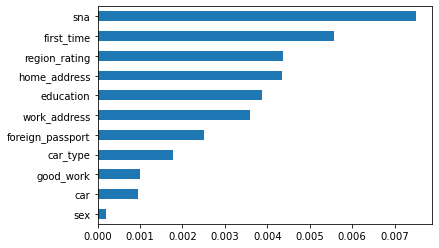

In [285]:
#проверка значимости категориальных признаков специальной функцией mutual_info_classif:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

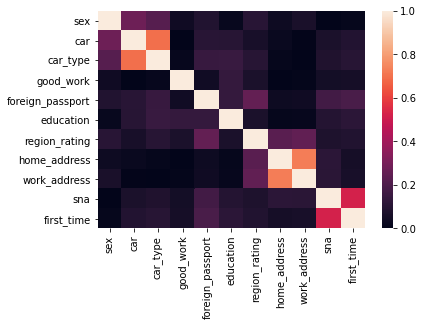

In [286]:
#оценка корелляции категориальных признаков:
sns.heatmap(df[bin_cols + cat_cols].corr().abs(), vmin=0, vmax=1)
#car_type,car -car кандидат для удаления - как менее значимый?
#work_address и home_address  - , удалить work_address?
#sna и first_time: удалить first_time? или сделать комбинацию этих признаков в новый признак

<AxesSubplot:>

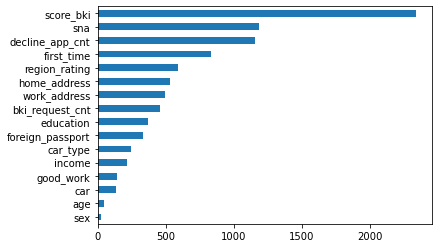

In [280]:
#результаты оценки значимости из всех признаков, включая числовые и категориальные
#методом f_classif не показывает явных противоречий оценке специальным методом mutual_info_classif:
#score_bki по-прежнему на первом месте
imp_num = pd.Series(f_classif(df[allfeatchers], df['default'])[0], index = allfeatchers)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

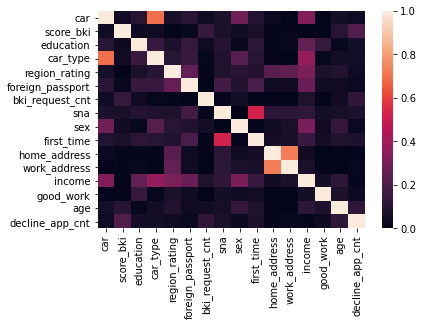

In [281]:
#оценка корелляции всех признаков:
sns.heatmap(df[allfeatchers].corr().abs(), vmin=0, vmax=1)

In [289]:
for i in (bin_cols+cat_cols):
    print(i, "vis_data:", vis_data[i].unique())
    print(i, "      df:", df[i].unique())    

sex vis_data: ['M' 'F']
sex       df: [1 0]
car vis_data: ['Y' 'N']
car       df: [1 0]
car_type vis_data: ['Y' 'N']
car_type       df: [1 0]
good_work vis_data: [0 1]
good_work       df: [0 1]
foreign_passport vis_data: ['N' 'Y']
foreign_passport       df: [0 1]
education vis_data: ['SCH' 'GRD' 'UGR' 'PGR' 'ACD' 'other']
education       df: [3 1 4 2 0 5]
region_rating vis_data: [50 80 60 40 70 20 30]
region_rating       df: [50 80 60 40 70 20 30]
home_address vis_data: [1 2 3]
home_address       df: [1 2 3]
work_address vis_data: [2 3 1]
work_address       df: [2 3 1]
sna vis_data: [4 1 2 3]
sna       df: [4 1 2 3]
first_time vis_data: [1 4 3 2]
first_time       df: [1 4 3 2]


In [291]:
#кодирование категориальных переменных
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
X_cat.shape

(73799, 27)

In [293]:
X_cat[:2,:]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.]])

In [295]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[num_cols].values)
X_num[:2,:]

array([[ 1.97211528, -0.42001208, -0.2087987 , -0.28100505, -0.78501579],
       [ 1.71170539, -0.42001208,  0.74754461,  0.77260728, -0.70752611]])

In [325]:
#визуализация соотношения вариантов целевой переменной в тренировочной и тестовой выборках
def visualize_train_valid_counts(init_data, train, valid):
    x = np.array([0, 1])
    width = 0.4

    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)

    classes = list(init_data['default'].value_counts().index)

    ax.bar(x - width, list(init_data['default'].value_counts()[classes]), width, color='r', label='Исходные данные')
    ax.bar(x, [np.sum(y_train==0),np.sum(y_train==1)], width, color='g', label='Тренировочная выборка')
    ax.bar(x, [np.sum(y_test==0),np.sum(y_test==1)], width, bottom=[np.sum(y_train==0),np.sum(y_train==1)], color='b', label='Валидационная выборка')

#     ax.set_ylim([0, 70])
    plt.xticks(x - width / 2, classes, fontsize=20)
    plt.yticks(fontsize=15)
    plt.xlabel('Значение целевой переменной default', fontsize=20)
    plt.ylabel('Кол-во примеров', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=15)

In [296]:
# Объединение подготовленных значений в единую группу для передачи в модель

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values
#разделение выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

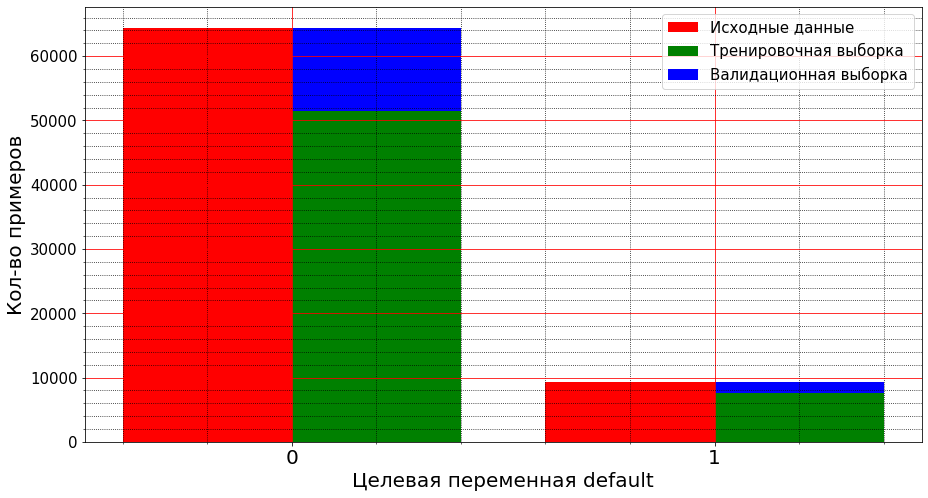

In [326]:
visualize_train_valid_counts(df, y_train, y_test)

In [297]:
def pltroc(fpr, tpr,roc_auc):#построение 
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()



In [301]:
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)
probs


array([[0.79359884, 0.20640116],
       [0.84469244, 0.15530756],
       [0.93794366, 0.06205634],
       ...,
       [0.89955721, 0.10044279],
       [0.90466987, 0.09533013],
       [0.94481549, 0.05518451]])

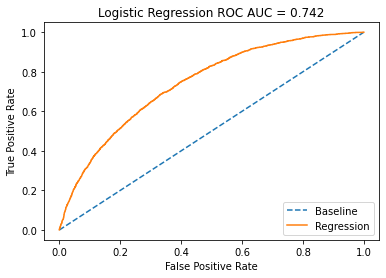

In [303]:
probs1 = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs1)
roc_auc = roc_auc_score(y_test, probs1)
pltroc(fpr, tpr,roc_auc)

51494
